# Instructions
Please run the following cells sequentially
1. (Optional) Running 1b adds semantic labels and requires addtional resources (default to a second GPU).
* The function relies on an additonal image captioning model, e.g., BLIP.  
* The labels are nouns, extracted from the generated caption. 
* It merge masks sharing the same label. 
2. Add your own image and update ``image_path`` variable. 
3. Feel free to play with DiffSeg hyper-parameters such as the ``KL_THRESHOLD``.

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


2023-11-23 11:15:44.644847: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-23 11:15:44.644871: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Import

In [4]:
import tensorflow as tf
from PIL import Image
import nltk
from transformers import AutoProcessor, TFBlipForConditionalGeneration
from keras_cv.src.models.stable_diffusion.image_encoder import ImageEncoder
from diffusion_models.stable_diffusion import StableDiffusion 
from diffusion_models.diffusion_model import SpatialTransformer
from utils import process_image, augmenter, vis_without_label, semantic_mask
from diffseg.segmentor import DiffSeg

is_noun = lambda pos: pos[:2] == 'NN'
# !nvidia-smi

# 1. Initialize SD Model

In [5]:
# Inialize Stable Diffusion Model on GPU:0 
with tf.device('/GPU:0'):
  image_encoder = ImageEncoder()
  vae=tf.keras.Model(
            image_encoder.input,
            image_encoder.layers[-1].output,
        )
  model = StableDiffusion(img_width=512, img_height=512)
blip = None

136824240/136824240 [==============================] - 2s 0us/step
By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


# 1b. Initialize BLIP (optional)

In [7]:
# Optionally initalize a BLIP captioning model on GPU:1
with tf.device('/GPU:0'):
    processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip = TFBlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

All model checkpoint layers were used when initializing TFBlipForConditionalGeneration.

All the layers of TFBlipForConditionalGeneration were initialized from the model checkpoint at Salesforce/blip-image-captioning-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBlipForConditionalGeneration for predictions without further training.


# 2. Run Inference on Real Images

In [8]:
# The first time running this cell will be slow
# because the model needs to download and loads pre-trained weights.

image_path = "./images/img5.jpeg" # Specify the path to your image

if blip is not None:
  with tf.device('/GPU:1'):
    inputs = processor(images=Image.open(image_path), return_tensors="tf")
    out = blip.generate(**inputs)
    prompt = processor.decode(out[0], skip_special_tokens=True)
    print(prompt)
else:
  prompt = None

with tf.device('/GPU:0'):
  images = process_image(image_path)
  images = augmenter(images)
  latent = vae(tf.expand_dims(images, axis=0), training=False)
  images, weight_64, weight_32, weight_16, weight_8, x_weights_64, x_weights_32, x_weights_16, x_weights_8 = model.text_to_image(
    prompt,
    batch_size=1,
    latent=latent,
    timestep=300
  )
  

/Users/chrisoffner3d/miniconda3/envs/dl_project/lib/python3.11/site-packages/transformers/generation/tf_utils.py:838: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a group of cars racing down a track
198180272/198180272 [==============================] - 3s 0us/step


In [11]:
weight_64.shape, weight_32.shape, weight_16.shape, weight_8.shape, x_weights_64.shape, x_weights_32.shape, x_weights_16.shape, x_weights_8.shape

((1, 8, 4096, 4096),
 (1, 8, 1024, 1024),
 (1, 8, 256, 256),
 (1, 8, 64, 64),
 (1, 8, 4096, 77),
 (1, 8, 1024, 77),
 (1, 8, 256, 77),
 (1, 8, 64, 77))

In [12]:
x_weights_8

array([[[[9.9516958e-01, 1.4802378e-04, 8.0700403e-05, ...,
          1.9451561e-05, 2.0358289e-05, 2.0141382e-05],
         [9.9538332e-01, 2.0243775e-05, 1.6274087e-05, ...,
          1.3440453e-05, 1.4234910e-05, 1.3959689e-05],
         [9.9312007e-01, 3.1483436e-05, 2.5677464e-05, ...,
          2.0626971e-05, 2.1889136e-05, 2.0958394e-05],
         ...,
         [9.9762696e-01, 1.5298293e-04, 1.4331778e-04, ...,
          9.3575691e-06, 9.9702038e-06, 9.8489645e-06],
         [9.9820340e-01, 1.3627982e-04, 9.4212097e-05, ...,
          7.5696021e-06, 8.0826430e-06, 8.1842700e-06],
         [9.9411976e-01, 5.4197788e-04, 2.0159883e-04, ...,
          1.7545779e-05, 1.8484732e-05, 1.8649831e-05]],

        [[9.9858761e-01, 1.3734716e-04, 6.9820351e-05, ...,
          6.5800532e-07, 6.9456405e-07, 7.2058123e-07],
         [9.9823028e-01, 1.2959665e-04, 1.4705377e-04, ...,
          8.7713141e-07, 9.2785547e-07, 9.6182202e-07],
         [9.9769372e-01, 2.4322681e-04, 1.7741714e-04, .

# 3. Generate Segementation Masks

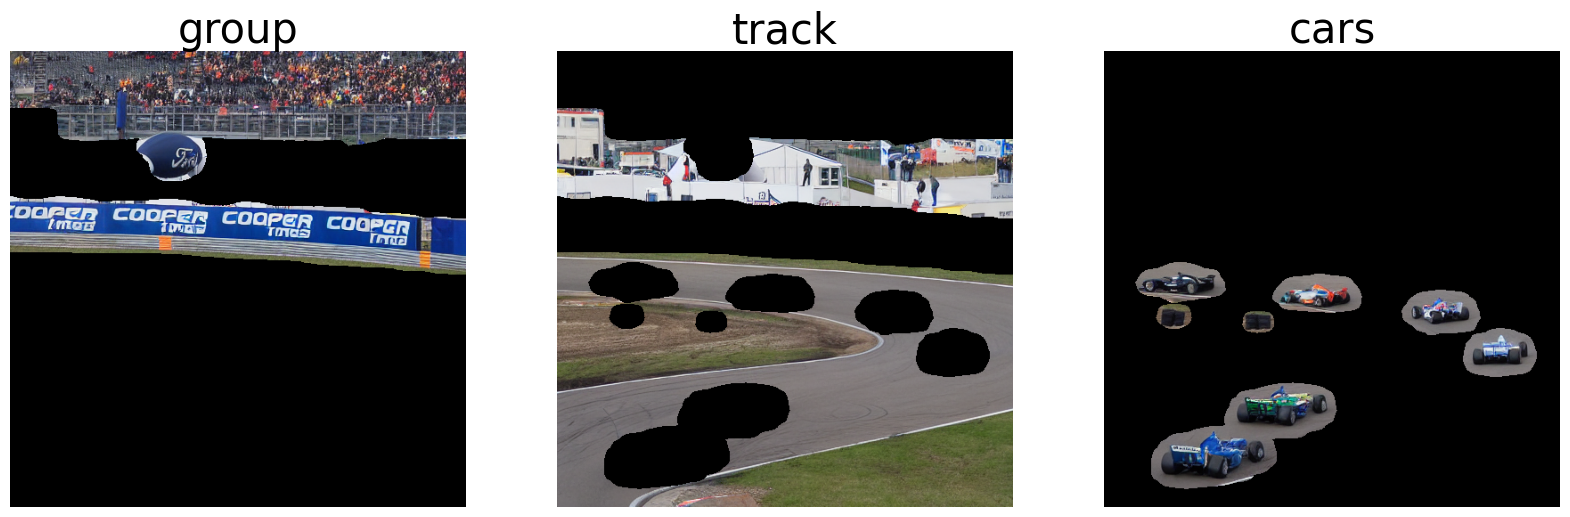

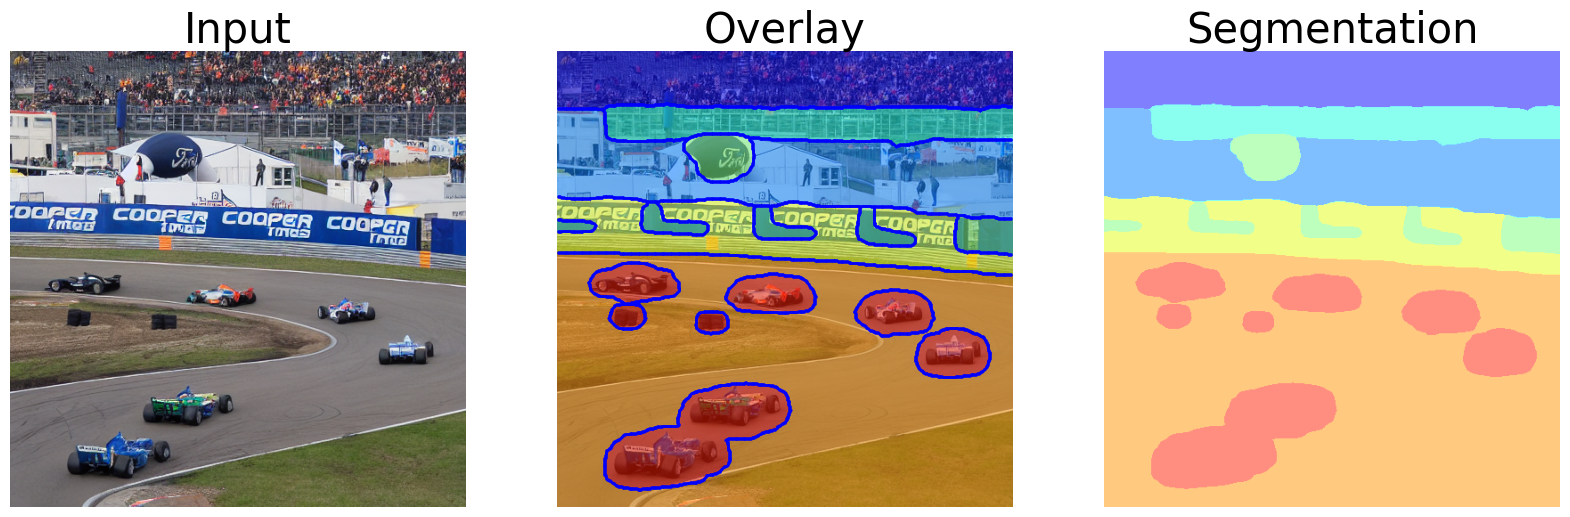

In [9]:
KL_THRESHOLD = [0.9]*3 # KL_THRESHOLD controls the merging threshold
NUM_POINTS = 16
REFINEMENT = True


with tf.device('/GPU:0'):
  segmentor = DiffSeg(KL_THRESHOLD, REFINEMENT, NUM_POINTS)
  pred = segmentor.segment(weight_64, weight_32, weight_16, weight_8) # b x 512 x 512
  if blip is not None:
    tokenized = nltk.word_tokenize(prompt)
    nouns = [(i,word) for i,(word, pos) in enumerate(nltk.pos_tag(tokenized)) if is_noun(pos)] 

  for i in range(len(images)):
    if blip is not None:
      x_weight = segmentor.aggregate_x_weights([x_weights_64[i],x_weights_32[i], x_weights_16[i], x_weights_8[i]],weight_ratio=[1.0,1.0,1.0,1.0])
      label_to_mask = segmentor.get_semantics(pred[i], x_weight[i], nouns,voting="mean")
      semantic_mask(images[i], pred[i], label_to_mask)
    vis_without_label(pred[i],images[i],num_class=len(set(pred[i].flatten())))

In [14]:
x_weights_8.shape

(1, 8, 64, 77)